# Statistical Programming in Python - Group Assignment, Group G

*In this Jupyer Notebook we are going to describe our approach to predict the total number of Washington D.C. bicycle users on an hourly basis.*

*The flow of our notebook will be the following:* 
- Setup
- Explanatory data analysis
- Feature Engineering
- Machine Learning

## Setup

*In this part we are going to import necessary packages and import the csv file.*

In [1]:
#Import the necessary libraries and objects
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import ipywidgets as ipw

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler

from datetime import date

In [2]:
# Load data 
df = pd.read_csv("hour.csv", index_col="instant", parse_dates=["dteday"])

# Renaming the columns for better readability
df = df.rename(columns={"hr": "hour", "cnt":"count", "dteday":"date"})

# Check if we got an unique index
df.index.is_unique

True

## Explanatory Data Analysis
*Using Exploratory Data Analysis to investigate the data set, to discover patterns, to spot anomalies and to check assumptions.
In this sections, we are going to analyze the quality of the data for each variable and also check for corellations with our target variable count.*
*We entered descriptions / assumptions when we thought something looked strange / was worth a deep-dive.*


### Feature creation for EDA

*We decided to work with two different dataframes. In the EDA section we are going to use the `df_eda` dataframe. We created the features for this dataframe in a normal pandas way. Within the Feature Engineering section we are going to create these features again but using sklearn functionality.*

#### Extraction of date components

*From the attribute date, which is a datetime object we are extracting year, month, day, weekday by using `pandas.series.dt`*

In [3]:
df_eda = df

# extract year, month, day, weekday
df_eda["year"] = df_eda["date"].dt.year
df_eda["month"] = df_eda["date"].dt.month
df_eda["day"] = df_eda["date"].dt.day
df_eda["weekday"]= df_eda["date"].dt.weekday

#### Create season column

*To check the data set for seasonality, the date needs to be assigned to the 4 seasons.* 
- 1 = spring (March 20 - June 21)
- 2 = summer (June 22 - September 21)
- 3 = fall (September 22 - December 20)
- 4 = winter (December 21 - March 19)


https://www.timeanddate.com/calendar/aboutseasons.html


In [4]:
def get_season(date_to_convert):  # the function expects a datetime.date object as input
    
    # fix the year of the input
    date_year = date_to_convert.year
    
    # create the list of tuples on which to loop
    seasons = [
        ("winter", date(date_year, 12, 21), date(date_year, 12, 31)),
        ("spring", date(date_year, 3, 20), date(date_year, 6, 21)),
        ("summer", date(date_year, 6, 22), date(date_year, 9, 21)),
        ("fall", date(date_year, 9, 22), date(date_year, 12, 20)),
        ("winter", date(date_year, 1, 1), date(date_year, 3, 19))
    ]
    
    # loop for each season trying to find the season to which
    # date_to_convert belongs to
    for elem in seasons:  # season = tuple(name, start, end) = (elem[0], elem[1], elem[2])
        if date_to_convert>=elem[1] and date_to_convert<=elem[2]:  
            return elem[0]
        
df_eda["season"] = df_eda["date"].map(get_season)


#### Create a holiday column

*By creating a Holiday Column it is possible to check for an increase in bike rental during the holiday season.*

In [5]:
cal = calendar() #Using calender object to extract holiday seasons
holidays = cal.holidays(start=df_eda["date"].min(), end=df_eda["date"].max())
df_eda["holiday"] = np.where(df_eda["date"].isin(holidays),True,False) 

#### Create a workingday column

*By creating a workingday column it is possible to check for an increase in bike rental during the weekend.*

Mon-Fri (0-4)

Sat-Sun (5-6)

In [6]:
df_eda["workingday"] = np.where(df_eda["weekday"] < 5,True,False)

### General Overview

*Have an overview of our data set, includes data type, number of rows, basic statistics of each column, NAs*

In [7]:
df_eda.shape[0]

17379

In [8]:
# Check data frame on anomalies
df_eda.describe()

,hour,temp,atemp,hum,windspeed,casual,registered,count,year,month,day,weekday
count,17379.000000,17280.000000,17279.000000,17279.000000,17279.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,11.546752,0.497071,0.475530,0.627235,0.190114,35.676218,153.786869,189.463088,2011.502561,6.537775,15.683411,3.011451
std,6.914405,0.192474,0.171782,0.193047,0.122378,49.305030,151.357286,181.387599,0.500008,3.438776,8.789373,2.001966
min,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000
25%,6.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000,2011.000000,4.000000,8.000000,1.000000
50%,12.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000,2012.000000,7.000000,16.000000,3.000000
75%,18.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000,2012.000000,10.000000,23.000000,5.000000
max,23.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000,2012.000000,12.000000,31.000000,6.000000


In [9]:
# Check data types
df_eda.dtypes

date          datetime64[ns]
hour                   int64
weathersit            object
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
count                  int64
year                   int64
month                  int64
day                    int64
weekday                int64
season                object
holiday                 bool
workingday              bool
dtype: object

In [10]:
# Check nulls
df_eda.isna().sum()

date            0
hour            0
weathersit    100
temp           99
atemp         100
hum           100
windspeed     100
casual          0
registered      0
count           0
year            0
month           0
day             0
weekday         0
season          0
holiday         0
workingday      0
dtype: int64

*Conclusion: After seeing the basic structure, we conclude that the overall quality seems to be good. There aren't any weird numbers or wrong types. Also there aren't many Null values in this dataframe.*






####  Hour column

##### Correctness & Consistency

In [11]:
# Check basic stats
df_eda["hour"].describe()

count    17379.000000
mean        11.546752
std          6.914405
min          0.000000
25%          6.000000
50%         12.000000
75%         18.000000
max         23.000000
Name: hour, dtype: float64

In [12]:
#Check missing values through distribution of the data set
plt.figure(figsize=(10,5))
sns.histplot(df_eda["hour"], kde=True)
plt.title("hour per day distribution");

AttributeError: module 'seaborn' has no attribute 'histplot'

<Figure size 720x360 with 0 Axes>

*We can see that the hours are not evenly distributed which seems wrong. There wo we'll go into a furter analysis.*

In [14]:
# Check which hours are missing
df_eda["hour"].value_counts().sort_values(ascending=True)

3     697
4     697
2     715
5     717
1     724
6     725
0     726
8     727
9     727
10    727
11    727
7     727
21    728
23    728
19    728
12    728
18    728
22    728
20    728
13    729
14    729
15    729
16    730
17    730
Name: hour, dtype: int64

*Having a look at the numbers, there aren't so many hours missing. When hours are missing on a day, it's usually in the early morning hours.*

In [15]:
# Check if each day has 24 hours
df_ob_date = df_eda[["date","hour"]].groupby(["date"], as_index=False).count().sort_values(by=["hour"])
df_ob_date

,date,hour
667,2012-10-29,1
26,2011-01-27,8
668,2012-10-30,11
17,2011-01-18,12
25,2011-01-26,16
...,...,...
279,2011-10-07,24
280,2011-10-08,24
281,2011-10-09,24
283,2011-10-11,24


##### NAs

In [16]:
df_eda["hour"].isna().sum()

0

##### Outliers

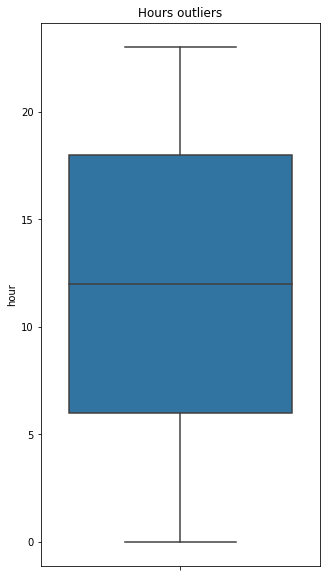

In [17]:
# Detect outliers
plt.figure(figsize=(5,10))
sns.boxplot(y="hour", data=df_eda, orient="v")
plt.title("Hours outliers");

####  Weathersit column

##### Correctness & Consistency

In [18]:
# Check basic stats
df_eda["weathersit"].describe()

count                                               17279
unique                                                  4
top       Clear, Few clouds, Partly cloudy, Partly cloudy
freq                                                11345
Name: weathersit, dtype: object

##### NAs

In [19]:
df_eda["weathersit"].isna().sum()

100

##### Outliers

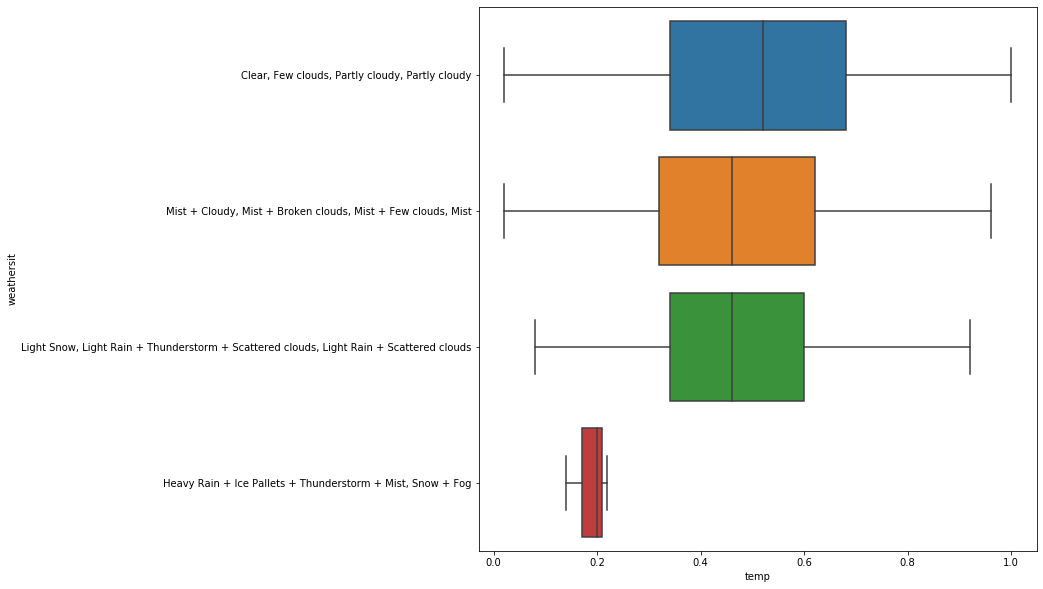

In [20]:
# Detect outliers
plt.figure(figsize=(10,10))
sns.boxplot(data=df_eda, y="weathersit", x="temp");

####  Temp column

##### Correctness & Consistency

In [21]:
# Check basic stats
df_eda["temp"].describe()

count    17280.000000
mean         0.497071
std          0.192474
min          0.020000
25%          0.340000
50%          0.500000
75%          0.660000
max          1.000000
Name: temp, dtype: float64

In [22]:
# Check distribution
plt.figure(figsize=(10,5))
sns.histplot(df_eda["temp"], kde=True)
plt.title("temp distribution");

AttributeError: module 'seaborn' has no attribute 'histplot'

<Figure size 720x360 with 0 Axes>

##### NAs

In [ ]:
# Check NAs
df_eda["temp"].isna().sum()

In [ ]:
df[df["temp"].isnull()]

*It seems like that null values are not clusters.*

##### Outliers

In [ ]:
# Detect outliers
plt.figure(figsize=(5,10))
sns.boxplot(y="temp", data=df_eda, orient="v")
plt.title("Temp outliers");

####  Atemp column

##### Correctness & Consistency

In [ ]:
# Check basic stats
df_eda["atemp"].describe()

In [ ]:
# Check distribution
plt.figure(figsize=(10,5))
sns.histplot(df_eda["atemp"], kde=True)
plt.title("atemp distribution");

##### NAs

In [ ]:
# Check for NAs
df_eda["atemp"].isna().sum()

In [ ]:
df[df["atemp"].isnull()]

*It seems like that null values are not clusters.*

##### Outliers

In [ ]:
# Detect outliers
plt.figure(figsize=(5,10))
sns.boxplot(y="atemp", data=df_eda, orient="v")
plt.title("Atemp outliers");

####  Hum column

##### Correctness & Consistency

In [ ]:
# Check basic stats
df_eda["hum"].describe()

In [ ]:
# Check distribution
plt.figure(figsize=(10,5))
sns.histplot(df_eda["hum"], kde=True)
plt.title("hum distribution");

In [ ]:
df_eda["hum"].value_counts()

##### NAs

In [ ]:
# Check NAs
df_eda["hum"].isna().sum()

In [ ]:
df[df["hum"].isnull()]

*It seems like that null values are not clusters.*

##### Outliers

In [ ]:
# Detect outliers
plt.figure(figsize=(5,10))
sns.boxplot(y="hum", data=df_eda, orient="v")
plt.title("Hum outliers");

####  Windspeed column

##### Correctness & Consistency

In [ ]:
# Check basic stats
df_eda["windspeed"].describe()

In [ ]:
# Check distribution
plt.figure(figsize=(10,5))
sns.histplot(df_eda["windspeed"], kde=True)
plt.title("windspeed distribution");

##### NAs

In [ ]:
# Check NAs
df_eda["windspeed"].isna().sum()

In [ ]:
df[df["windspeed"].isnull()]

*It seems like that null values are not clusters.*

##### Outliers

In [ ]:
# Detect outliers
plt.figure(figsize=(5,10))
sns.boxplot(y="windspeed", data=df_eda, orient="v")
plt.title("Windspeed outliers");

### EDA target variable


### Count analyis

*Target variable is count which is a summation of casual and registered users in this data set.*

#### Outliers


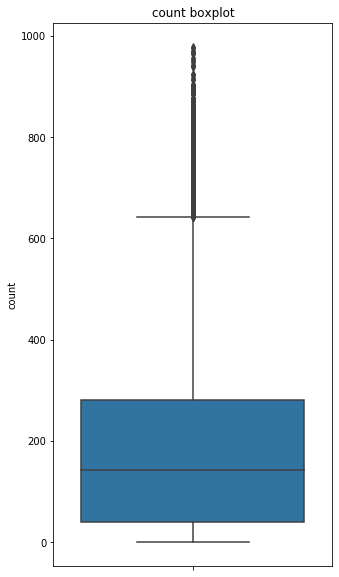

In [23]:
# Check boxplot on outliers
plt.figure(figsize=(5,10))
sns.boxplot(data=df_eda,y="count",orient="v")
plt.title("count boxplot");

*Conclusion: Detecting outliers in the count boxplot, further investigation will be shown further down in the code*

#### Distribution

In [24]:
# Distribution of count attribute
plt.figure(figsize=(10,5))
sns.displot(df_eda["count"])
plt.title("count distribution");

AttributeError: module 'seaborn' has no attribute 'displot'

<Figure size 720x360 with 0 Axes>

*Conclusion: The distribution of the count shows that it is not normally distributed and is right skewed distributed. For the next step log will be used to see if a normal distribution can be achieved.*

In [25]:
# As the distribution was skewed, log transformation is used on count attribute
plt.figure(figsize=(10,5))
sns.displot(np.log(df_eda["count"]), kde=True)
plt.title("log(count) distribution");

AttributeError: module 'seaborn' has no attribute 'displot'

<Figure size 720x360 with 0 Axes>

*Conclusion: with the log the distribution is getting closer to a normal distribution. We are going to use log(count) in our model.*

### Time related analsysis

*Target variable is date. EDA is performed on date components and seasons.*

#### Outliers

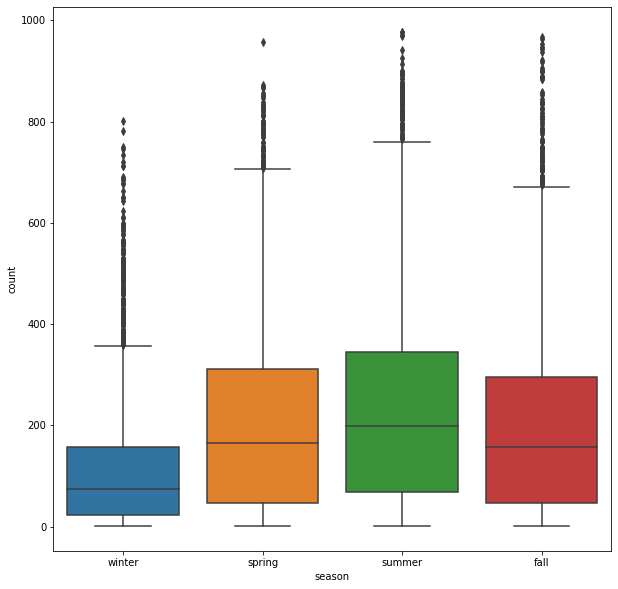

In [26]:
# Detect outliers based on seasonality, hours or years
@ipw.interact(column_name = ipw.Dropdown(options = ["season","hour","year"]))
def out_graph(column_name):
      plt.figure(figsize=(10,10))
      sns.boxplot(data=df_eda,y="count", x = df_eda[column_name], orient="v")

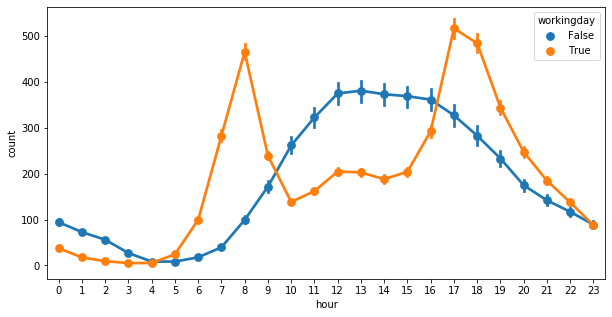

In [27]:
#Check the distribution working day per hour vs count
plt.figure(figsize=(10,5))
sns.pointplot(x="hour", y="count", data=df_eda, hue="workingday");

*Conclusion: During the workday it is visible that the demand of bike rentals are increasing during the normal rush hours. On the weekends curve has it's peak during lunch time. This explains also the outliers in the previous graphs. Therefore the hours and workingdays are necessary and will be used in the feature engineering part*

In [ ]:
#Check the distribution weather vs count or season vs count
@ipw.interact(column_name = ipw.Dropdown(options = ["season","weathersit"]))
def out_graph(column_name):
    sns.pointplot(data=df_eda,y="count", x = "hour", hue=df_eda[column_name], orient="v")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

*Conclusion: Rental numbers are following the same pattern in the different seasons and in the different weathersituations. The seasons and the weathersituation are also necessary indicators and will be used for the feature engineering part*

*Null values: The null values are in columns that are weather related and randomly splitted. We will use a KNNInputer because these values can be normally imputed by its neighbors.*

*Outliers: Based on the different weather and sitaution which impacts the count, we are not going to drop any outliers*

### Correlations

In [ ]:
# CORRELATION HEATMAP
corr = df_eda.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,annot = False, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
corr

In [ ]:
sns.pairplot(corr)

*Conclusion: Weekday and workingday are highly correlated which makes obviously sense. We can assume that casual bookings occur more often on the weekend. Also we can observe a high correlation (0.98) between atemp and temp.*

## Feature Engineering

*Defining the function, which will be used to transform the attributes of the data set.*

### Feature Creation

*During the analysis we have seen that variables like season and workingday are important. In this section we are going to create the same logic but implementing them in the sklearn mehthdology (e.g. `FunctionTransformer`) to benefit from its extensive capabilites.*

#### Create season column

In [ ]:
def season_extractor(series):
    def get_season(date_to_convert):  # the function expects a datetime.date object as input
        
        # fix the year of the input
        date_year = date_to_convert.year
        
        # create the list of tuples on which to loop
        seasons = [
            (0, date(date_year, 12, 21), date(date_year, 12, 31)),
            (1, date(date_year, 3, 20), date(date_year, 6, 21)),
            (2, date(date_year, 6, 22), date(date_year, 9, 21)),
            (3, date(date_year, 9, 22), date(date_year, 12, 20)),
            (0, date(date_year, 1, 1), date(date_year, 3, 19))
        ]
        
        # loop for each season trying to find the season to which
        # date_to_convert belongs to
        for elem in seasons:  # season = tuple(name, start, end) = (elem[0], elem[1], elem[2])
            if date_to_convert>=elem[1] and date_to_convert<=elem[2]:  
                return elem[0]   
            
    return series.map(get_season).to_frame()

season_extractor = FunctionTransformer(season_extractor)

#### Create holiday column

In [ ]:
def holiday_extractor(series):
    df=pd.DataFrame()
    cal = calendar()
    holidays = cal.holidays(start=series.min(), end=series.max())
    df["Holiday"]=np.where(series.dt.day.isin(holidays),True,False)
    return df

holiday_extractor = FunctionTransformer(holiday_extractor)

#### Create a workingday column

In [ ]:
def workingday_extractor(series):
        df=pd.DataFrame()
        df["Workingday"]=np.where(series.dt.weekday < 5,True,False)
        return df

workingday_extractor = FunctionTransformer(workingday_extractor)

#### Create year column

In [ ]:
def year_extractor(series):
    df=pd.DataFrame()
    df["year"]=series.dt.year
    return df
 
year_extractor = FunctionTransformer(year_extractor)

#### Create month column

In [ ]:
def month_extractor(series):
    df=pd.DataFrame()
    df["month"]=series.dt.month
    return df
 
month_extractor = FunctionTransformer(month_extractor)

#### Create day column

In [ ]:
def day_extractor(series):
    df=pd.DataFrame()
    df["day"]=series.dt.day
    return df
 
day_extractor = FunctionTransformer(day_extractor)

#### Weekday Extractor

In [ ]:
def weekday_extractor(series):
    df = pd.DataFrame()
    df["Weekday"] = series.dt.weekday
    return df
 
weekday_extractor = FunctionTransformer(weekday_extractor)

### Helper functions

*For the following transformation of the columns additional functions were created which were not provided by sklearn*

In [ ]:
# Encode the weathersit. E.g. sklearn's OrdinalEncoder cannot handle null values (documentaion is faulty)
def categorizer(series):
    
    def encode(weathersit):
        if weathersit == "Clear, Few clouds, Partly cloudy, Partly cloudy":
            return 0
        elif weathersit == "Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist":
            return 1
        elif weathersit == "Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds":
            return 2
        elif weathersit == "Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog":
            return 3
        else:
            return weathersit
        
    return series.map(encode).to_frame()


weathersit_encoder = FunctionTransformer(categorizer)

In [ ]:
# Rounds the derived values from the KNNImputer back to integers and therefore in the proper category
def rounder(series):
    return pd.DataFrame(np.rint(series))

weathersit_rounder = FunctionTransformer(rounder)

## Model Building

*With all the exploration done on the dataset, we have enough insights to determine which attributes are the determining factor to predict the count for bicycle riders.*

### Basic Model Building
The count being a continuous variable, to predict it we need the Regressor family models, such as Linear Regression, Random Forest Regression to predict.

As a start to build this model, we take only these facts into consideration:
1. The dataset in its original state has NA values,
2. The Regression models only work with numerical data.

For simplicity and to start our journey, we discard the observations with contains the NA and as independent variables we only take the numerical ones ( temp, atemp, hum, windspeed ) into consideration

###  Cross Validation with TimeSeriesSplit

#### Required functions

We are not using the TimeSeriesSplit() of sklearn because of the following reasons:
1. this method splits it into train\test sets in a “sliding window” approach, but it doesn’t allow us to choose the sets sizes, we can only choose how many splits we would like to have.
2. Scikit-learn TimeSeriesSplit also assumes that there is one observation per date

Thus we user-defined functions, as we have multiple observations per date

Code from: https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8

In [ ]:
import pandas as pd
import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *

class TimeBasedCV(object):
    '''
    Parameters 
    ----------
    train_period: int
        number of time units to include in each train set
        default is 30
    test_period: int
        number of time units to include in each test set
        default is 7
    freq: string
        frequency of input parameters. possible values are: days, months, years, weeks, hours, minutes, seconds
        possible values designed to be used by dateutil.relativedelta class
        deafault is days
    '''
    
    
    def __init__(self, train_period=30, test_period=7, freq='days'):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq

        
        
    def split(self, data, validation_split_date=None, date_column='date', gap=0):
        '''
        Generate indices to split data into training and test set
        
        Parameters 
        ----------
        data: pandas DataFrame
            your data, contain one column for the record date 
        validation_split_date: datetime.date()
            first date to perform the splitting on.
            if not provided will set to be the minimum date in the data after the first training set
        date_column: string, deafult='record_date'
            date of each record
        gap: int, default=0
            for cases the test set does not come right after the train set,
            *gap* days are left between train and test sets
        
        Returns 
        -------
        train_index ,test_index: 
            list of tuples (train index, test index) similar to sklearn model selection
        '''
        
        # check that date_column exist in the data:
        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []

        if validation_split_date==None:
            validation_split_date = data[date_column].min().date() + eval('relativedelta('+self.freq+'=self.train_period)')
        
        start_train = validation_split_date - eval('relativedelta('+self.freq+'=self.train_period)')
        end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
        start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
        end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        while end_test < data[date_column].max().date():
            # train indices:
            cur_train_indices = list(data[(data[date_column].dt.date>=start_train) & 
                                     (data[date_column].dt.date<end_train)].index)

            # test indices:
            cur_test_indices = list(data[(data[date_column].dt.date>=start_test) &
                                    (data[date_column].dt.date<end_test)].index)
            
            print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
                 "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)

            # update dates:
            start_train = start_train + eval('relativedelta('+self.freq+'=self.test_period)')
            end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
            start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
            end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        # mimic sklearn output  
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        
        return index_output
    
    
    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits 

In [ ]:
# The below function is defined which will fit the train data on the model we choose, 
# and calculate the predictions based on our test set
# Also, prints out the R2 Score for that model
def fit_predict(clf, X_train, y_train, X_test, y_test):
    
    # Step 1: Log Transformation of Target Value y
    log_y = np.log1p(y_train)  
    
    # Step 2: Fit the train data
    clf.fit(X_train, log_y)    

    # Step 3 : Predict
    prediction = clf.predict(X_test)

    # Step 4 : Evaluate
    print('R2 Value:',metrics.r2_score(np.log1p(y_test), prediction))
    # plot for residual error
 
    # setting plot style
    plt.style.use('fivethirtyeight')
    
    # plotting residual errors in test data
    plt.scatter(clf.predict(X_test), clf.predict(X_test) - np.log1p(y_test),
                color = "blue", s = 5, label = 'Test data')
     
    # plotting line for zero residual error
    plt.hlines(y = 0, xmin = 2, xmax = 6, linewidth = 2)
     
    # plotting legend
    plt.legend(loc = 'upper right')
     
    # plot title
    plt.title("Residual errors")
     
    # method call for showing the plot
    plt.show()

In [ ]:
# Load data 
df = pd.read_csv("hour.csv", index_col="instant", parse_dates=["dteday"])

df = df.rename(columns={"hr": "hour", "cnt":"count", "dteday":"date"})

We re-read the data, so that we are able to drop the NA rows and even drop the date as it will be dealt with later.

We split on the basis of the date provided to us,
1. Train set: whole 2011, till 3rd quarter of 2012
2. Test set: 4th quarter of 2012

In [ ]:
date_split = pd.to_datetime("2012-10-01")

#Basic model so dropiing the NAs
df=df.dropna()

# training vs target
x = df.drop(["count","registered","casual"], axis=1)
y = df[["date","count"]]

# splitting data
X_train = x[x["date"] < date_split].drop("date", axis=1)
X_test = x[x["date"] >= date_split].drop("date", axis=1)
y_train = y[y["date"] < date_split].drop("date", axis=1).values.ravel()
y_test = y[y["date"] >= date_split].drop("date", axis=1).values.ravel()
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

In [ ]:
# selecting only the numeric columns to build a base model
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])


#### Linear Regression
The type of Linear Regression we will be dealing with, is the Ordinary least squares Linear Regression, who main aim is to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

In [ ]:
from sklearn.linear_model import LinearRegression

# create linear regression object
clf=LinearRegression()

# train the model using the training sets
clf.fit(X_train, y_train)

# predict the model on the test set
prediction=clf.predict(X_test)

from sklearn import metrics
# Measuring Goodness of fit in Training data
print('R2 Value:',metrics.r2_score(y_test, prediction))

# plot for residual error
 
# setting plot style
plt.style.use('fivethirtyeight')

# plotting residual errors in test data
plt.scatter(clf.predict(X_test), clf.predict(X_test) - np.log1p(y_test),
            color = "blue", s = 5, label = 'Test data')
 
# plotting line for zero residual error
plt.hlines(y = 0, xmin = -100, xmax = 500, linewidth = 2)
 
# plotting legend
plt.legend(loc = 'upper right')
 
# plot title
plt.title("Residual errors")
 
# method call for showing the plot
plt.show()


In [ ]:
df = pd.read_csv("hour.csv", index_col="instant", parse_dates=["dteday"])

df = df.rename(columns={"hr": "hour", "cnt":"count", "dteday":"date"})

df = df.dropna()

# Split and build the train and test set
tscv = TimeBasedCV(train_period=120,
                   test_period=30,
                   freq='days')
for train_index, test_index in tscv.split(df,
                   validation_split_date=datetime.date(2011,5,1), date_column='date'):
    print(train_index, test_index)

# get number of splits
tscv.get_n_splits()

# Prepare the X and y sets
X = df.drop(["count","casual","registered","weathersit"], axis=1)
y = df["count"]


r2scorear = []
for train_index, test_index in tscv.split(X, validation_split_date=datetime.date(2011,5,1)):

    data_train   = X.loc[train_index].drop('date', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('date', axis=1)
    target_test  = y.loc[test_index]

    # Fit on the different train and test set
    clf.fit(data_train,np.log1p(target_train))

    preds = clf.predict(data_test)

    # r@ Score for the current fold only    
    r2score = metrics.r2_score(preds,np.log1p(target_test))
    
    #Append to the final array
    r2scorear.append(r2score)

# this is the average r2-score over all folds
average_r2 = np.mean(r2scorear)

# Plot the different r2 scores
plt.plot(r2scorear)

# Print the average r2 throughout
print("R2-score:",average_r2)

#### R2 Metric Measure
The coefficient of determination (R-squared) is a statistical metric that is used to measure how much of the variation in outcome can be explained by the variation in the independent variables. 

R2 can only range between 0 and 1, where 0 indicates that the outcome cannot be predicted by any of the independent variables and 1 indicates that the outcome can be predicted without error from the independent variables. Even we get R2 in negative, which tells the the chosen model fits worse than a horizontal line.

Problem with R2 metric:
R2 always increases as more predictors are added to the Linear model, even though the predictors may not be related to the outcome variable.

In our case, this simple model is able to explain 13% variation of the count can be explained by the variation in the independent variable. 

In [ ]:
#Checking the Residuals
sns.distplot((np.log1p(y_test) -prediction), bins = 50)

#####  Linear Regression with Ridge

Our, first attempt, would be introducing the loss function in the linear least squares function and regularization is given by the L2 normalization. L2 regularization adds an L2 penalty, which equals the square of the magnitude of coefficients. All coefficients are shrunk by the same factor (so none are eliminated). It is given by the below formula:
![image-2.png](attachment:image-2.png)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Step 1 : Create Model
ridge_model = Ridge(random_state=42)

# Hyper-parameter List
ridge_params = {'max_iter':[3000], 'alpha':[0.5, 0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}

# Evaluate Function for Cross-Validation (R2 score)
r2_scorer = metrics.make_scorer(metrics.r2_score, greater_is_better=True) 

tscv=TimeBasedCV(train_period=120,
                   test_period=30,
                   freq='days')

for train_index, test_index in tscv.split(df,
                   validation_split_date=datetime.date(2011,5,1), date_column='date'):
    print(train_index, test_index)
    
# Step 2 : Create GridSearchCV Object (with Ridge)
gridsearch_ridge_model = GridSearchCV(estimator=ridge_model,
                                      param_grid=ridge_params,
                                      scoring=r2_scorer,
                                      cv=tscv.get_n_splits())

# Step 3 : Perform Grid Search
log_y = np.log1p(y_train) # Log Transformation of Target Value y
gridsearch_ridge_model.fit(X_train, log_y) # Train (Grid Search)

print('Best Parameter:', gridsearch_ridge_model.best_params_)

# Step 4 : Predict with the best estimator from the parameter list
prediction = gridsearch_ridge_model.best_estimator_.predict(X_test)

# Step 5 : Evaluate
print('R2 Value:',metrics.r2_score(np.log1p(y_test), prediction))

# Step 6 : plot for residual error

# plotting residual errors in test data
plt.scatter(clf.predict(X_test), clf.predict(X_test) - np.log1p(y_test),
            color = "blue", s = 5, label = 'Test data')
 
# plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 10, linewidth = 2)
 
# plotting legend
plt.legend(loc = 'upper right')
 
# plot title
plt.title("Residual errors")
 
# method call for showing the plot
plt.show()


We introduced GridSearchCV to get the value for the optimum value for penalty to be introduced within the model. With our current model, the penalty calculated was 30.

#####  Linear Regression with Lasso

Similar to Ridge, Lasso introduced a loss function performing L1 regularization, which adds a penalty equal to the absolute value of the magnitude of coefficients. It is given by the formula:
![image.png](attachment:image.png)
Problem with this model being, this can result in sparse models with few coefficients; Some coefficients can become zero and eliminated from the model.

In [ ]:
from sklearn.linear_model import Lasso

# Step 1: Create Model
lasso_model = Lasso(random_state=42)

# Hyper-parameter List
lasso_alpha = 1/np.array([0.5, 0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = {'max_iter':[3000], 'alpha':lasso_alpha}

# Using time Based Splits
tscv=TimeBasedCV(train_period=120,
                   test_period=30,
                   freq='days')

for train_index, test_index in tscv.split(df,
                   validation_split_date=datetime.date(2011,5,1), date_column='date'):
    print(train_index, test_index)

# Step 2: Create GridSearchCV Object (with Lasso)
gridsearch_lasso_model = GridSearchCV(estimator=lasso_model,
                                      param_grid=lasso_params,
                                      scoring=r2_scorer,
                                      cv=tscv.get_n_splits())


# Step 3 : Perform Grid Search
log_y = np.log1p(y_train)
gridsearch_lasso_model.fit(X_train, log_y) # Train (Grid Search)

print('Best Parameter:', gridsearch_lasso_model.best_params_)

# Step 4 : Predict with the best estimator from the parameter list
prediction = gridsearch_lasso_model.best_estimator_.predict(X_test)

# Step 5 : Evaluate
print('R2 Value:',metrics.r2_score(np.log1p(y_test), prediction))

# Step 6: plot for residual error
 
# setting plot style
plt.style.use('fivethirtyeight')

# plotting residual errors in test data
plt.scatter(clf.predict(X_test), clf.predict(X_test) - np.log1p(y_test),
            color = "blue", s = 5, label = 'Test data')
 
# plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 10, linewidth = 2)
 
# plotting legend
plt.legend(loc = 'upper right')
 
# plot title
plt.title("Residual errors")
 
# method call for showing the plot
plt.show()

Similar to Ridge() we introduced GridSearchCV to get the value for the optimum value for penalty to be introduced within the model. With our current model, the penalty calculated was 0.003.

But, still we can find a pattern within out residuals, so the model has possibilities of further development.

##### Random Forest Regressor

A random forest regressor is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting, decreasig variance and fixing the problem of overfitting.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Step 1: Create Model
randomforest_model = RandomForestRegressor()

# Hyper-parameter List
rf_params = {'random_state':[42], 'n_estimators':[5, 10, 50, 100, 300]}

# Using time Based Splits
tscv=TimeBasedCV(train_period=120,
                   test_period=30,
                   freq='days')

for train_index, test_index in tscv.split(df,
                   validation_split_date=datetime.date(2011,5,1), date_column='date'):
    print(train_index, test_index)


# Step 2: Create GridSearchCV Object (with Random Forest Regression)
gridsearch_random_forest_model = GridSearchCV(estimator=randomforest_model,
                                              param_grid=rf_params,
                                              scoring=r2_scorer,
                                              cv=tscv.get_n_splits())

# Step 3 : Perform Grid Search
log_y = np.log1p(y_train)
gridsearch_random_forest_model.fit(X_train, log_y)

print('Best Parameter:', gridsearch_random_forest_model.best_params_)

# Step 4 : Predict with the best estimator from the parameter list
prediction = gridsearch_random_forest_model.best_estimator_.predict(X_test)

# Step 5 : Evaluate
print('R2 Value:',metrics.r2_score(np.log1p(y_test), prediction))

# Step 6 : Plot the residuals

# plotting residual errors in test data
plt.scatter(clf.predict(X_test), clf.predict(X_test) - np.log1p(y_test),
            color = "blue", s = 5, label = 'Test data')
 
# plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 10, linewidth = 2)
 
# plotting legend
plt.legend(loc = 'upper right')
 
# plot title
plt.title("Residual errors")
 
# method call for showing the plot
plt.show()

Lets look at the evolution as we increase the number of estimators, and how the Training and test r2 score changes

In [ ]:
trees_range = [5, 10, 50, 100, 300]
r2score = []

# looping through values of max_depth
for i, trees in enumerate(trees_range):
    
    # train
    rf = RandomForestRegressor(n_estimators=trees, random_state=42)
    rf.fit(X_train, np.log1p(y_train))
    
    # predict
    y_hat_train = rf.predict(X_train)
    y_hat_test = rf.predict(X_test)
    
    # evaluate
    r2_train = metrics.r2_score(np.log1p(y_train), y_hat_train)
    r2_test = metrics.r2_score(np.log1p(y_test), y_hat_test)
    
    # store results
    r2score.append({
        "n_trees": trees, 
        "r2_train": r2_train,
        "r2_test": r2_test
    })
    
    # print evolution of loop:
    print(f"N_trees: {trees}, r2_train: {r2_train:.3f}, r2_test={r2_test:.3f}")
    
# saving results as dataframe
results = pd.DataFrame(r2score)

# plotting
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(results["n_trees"], results["r2_train"], label="training r2", color="blue")
ax.plot(results["n_trees"], results["r2_test"], label="test r2", color="orange")
ax.legend(fontsize=12)

plt.show()

It is evident from this graph that with estimator size 100, somehow the r2 score saturates, though the GridSearchCv provides with best estimators as 300, it is logical to use 100 estimators as with furthur growth there is not much improvement in the performance.

##### Gradient Boosting Regressor

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees - which is the weak learner, building the model in a stage-wise fashion like other boosting methods do, to form one single strong learner in an iterative fashion.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Step 1: Create Model
gradientboosting_model = GradientBoostingRegressor(random_state=42)

# Hyper-parameter List
rf_params = {'random_state':[42], 'n_estimators':[100, 300, 500]}
# Step 2: Create GridSearchCV Object
gridsearch_gradientboost_forest_model = GridSearchCV(estimator=gradientboosting_model,
                                              param_grid=rf_params,
                                              scoring=r2_scorer,
                                              cv=5)

# Step 3 : Perform Grid Search
log_y = np.log1p(y_train)
gridsearch_gradientboost_forest_model.fit(X_train, log_y)

print('Best Parameter:', gridsearch_gradientboost_forest_model.best_params_)

# Step 4 : Predict with the best parameter
prediction = gridsearch_gradientboost_forest_model.best_estimator_.predict(X_test)

# Step 5 : Evaluate
print('R2 Value:',metrics.r2_score(np.log1p(y_test), prediction))

# Step 6 : Plot the residuals

# plotting residual errors in test data
plt.scatter(clf.predict(X_test), clf.predict(X_test) - np.log1p(y_test),
            color = "blue", s = 5, label = 'Test data')
 
# plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 10, linewidth = 2)
 
# plotting legend
plt.legend(loc = 'upper right')
 
# plot title
plt.title("Residual errors")
 
# method call for showing the plot
plt.show()

Lets look at the evolution as we increase the number of estimators, and how the Training and test r2 score changes

In [ ]:
trees_range = [5, 10, 50, 100, 300]
error_results = []

# looping through values of max_depth
for i, trees in enumerate(trees_range):
    
    # train
    rf = GradientBoostingRegressor(n_estimators=trees, random_state=42)
    rf.fit(X_train,np.log1p(y_train))
    
    # predict
    y_hat_train = rf.predict(X_train)
    y_hat_test = rf.predict(X_test)
    
    # evaluate
    r2_train = metrics.r2_score(np.log1p(y_train), y_hat_train)
    r2_test = metrics.r2_score(np.log1p(y_test), y_hat_test)
    
    # store results
    error_results.append({
        "n_trees": trees, 
        "r2_train": r2_train,
        "r2_test": r2_test
    })
    
    # print evolution of loop:
    print(f"N_trees: {trees}, r2_train: {r2_train:.3f}, r2_test={r2_test:.3f}")
    
# saving results as dataframe
results = pd.DataFrame(error_results)

# plotting
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(results["n_trees"], results["r2_train"], label="training r2", color="blue")
ax.plot(results["n_trees"], results["r2_test"], label="test r2", color="orange")
ax.legend(fontsize=12)

plt.show()

#### Time Series Split - Gradient Boosting Regressor
With such high r2 score in a basic model we need to check if, it is same throughout the dataset, when we change train and test in a 'rolling-window' approach.

In [ ]:
df = pd.read_csv("hour.csv", index_col="instant", parse_dates=["dteday"])

df = df.rename(columns={"hr": "hour", "cnt":"count", "dteday":"date"})

df = df.dropna()

tscv = TimeBasedCV(train_period=60,
                   test_period=7,
                   freq='days')
for train_index, test_index in tscv.split(df,
                   validation_split_date=datetime.date(2011,3,1), date_column='date'):
    print(train_index, test_index)

# get number of splits
tscv.get_n_splits()

#### Example- compute average test sets score: ####
X = df.drop(["count","casual","registered","weathersit"], axis=1)
y = df["count"]

r2scorear = []
for train_index, test_index in tscv.split(X, validation_split_date=datetime.date(2011,3,1)):

    data_train   = X.loc[train_index].drop('date', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('date', axis=1)
    target_test  = y.loc[test_index]


    clf = GradientBoostingRegressor(n_estimators=trees, random_state=42)
    clf.fit(data_train,np.log1p(target_train))

    preds = clf.predict(data_test)

    # accuracy for the current fold only    
    r2score = metrics.r2_score(preds,np.log1p(target_test))

    r2scorear.append(r2score)

# this is the average accuracy over all folds
average_r2 = np.mean(r2scorear)

plt.plot(r2scorear)

print("R2-score:",average_r2)


Similar to Random Forest regressor with estimator size 100, the r2 score saturates in Gradient Boosting Regressor, though the GridSearchCv provides with best estimators as 300, it is logical to use 100 estimators in this case too.

##### Support Vector Regression

An SVM model is basically a representation of different classes in a hyperplane in multidimensional space. The hyperplane will be generated in an iterative manner by SVM so that the error can be minimized. The goal of SVM is to divide the datasets into classes to find a maximum marginal hyperplane. The main parameter here being:

Kernel: A kernel helps us find a hyperplane in the higher dimensional space without increasing the computational cost. Usually, the computational cost will increase if the dimension of the data increases. This increase in dimension is required when we are unable to find a separating hyperplane in a given dimension and are required to move in a higher dimension.

We will be playing with this to build linear and non linear regression models

In [ ]:
from sklearn.svm import SVR

# Step 1: Create Model
svr_model = SVR()

# Hyper-parameter List
rf_params = {'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),}
             #'C' : [1,5,10],
             #'gamma' : ('auto','scale')}
        
# Step 2 : Create GridSearchCV Object
gridsearch_svr_model = GridSearchCV(estimator=svr_model,
                                              param_grid=rf_params,
                                              scoring=r2_scorer,
                                              cv=3, n_jobs = -1, verbose = 2)

# Step 3 : Perform Grid Search
log_y = np.log1p(y_train)
gridsearch_svr_model.fit(X_train, log_y)

print('Best Parameter:', gridsearch_svr_model.best_params_)

# Step 4 : Predict with the best parameter
prediction = gridsearch_svr_model.best_estimator_.predict(X_test)

# Evaluate
print('R2 Value:',metrics.r2_score(np.log1p(y_test), prediction))


We can see out of all the linear and non linear models, radial basis function kernel, or RBF kernel, provides us with best R2 score, though the R2 score is much lesser than the tree based regressors. In future models thus we will only be concentrating on Linear and tree based regression models.

#### Basic Data Manipulation

We will start with our feature engineering. First step, we will be defining a Column Transformer, imputing the NA values and the not required columns from the dataset. We are dropping atemp as the data distribution is similar and highly correlated to 'temp' attribute and thus, we are using 'temp' for the further models.

In [ ]:
# Load data 
df = pd.read_csv("hour.csv", index_col="instant", parse_dates=["dteday"])

df = df.rename(columns={"hr": "hour", "cnt":"count", "dteday":"date"})

In [ ]:
date_split = pd.to_datetime("2012-10-01")

# training vs target
x = df.drop(["count","registered","casual"], axis=1)
y = df[["date","count"]]

# splitting data
X_train = x[x["date"] < date_split]
X_test = x[x["date"] >= date_split]
y_train = y[y["date"] < date_split].drop("date", axis=1).values.ravel()
y_test = y[y["date"] >= date_split].drop("date", axis=1).values.ravel()
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Following steps are done in the  Column Trnsformer:

1. NA values are imputed, with KNNImputer, with neighbourhood size as 200. We are using KNN imputer as the temperature, humidity and windspeed would most likely be similar to the neighbouring datasets.
2. We are using Standard Scaler by removing the mean and scaling to unit variance of all the continuous variables within the same range.

In [ ]:
# Lets remove atemp as it is similar to temp and define a column transformer
preprocessing = ColumnTransformer([
    
    ("temp_encoder", Pipeline([
    ("temp_imputer",KNNImputer(n_neighbors=200)),
    ("temp_scaler", StandardScaler())
        
  ]), ["temp"]), # Temperature Imputer and Standard Scaler

    ("hum_encoder", Pipeline([
    ("hum_imputer",KNNImputer(n_neighbors=200)),
    ("hum_scaler", StandardScaler())
        
  ]), ["hum"]), # Humidity Imputer and Standard Scaler
    
    ("ws_encoder", Pipeline([
    ("ws_imputer",KNNImputer(n_neighbors=200)),
    ("windspeed_scaler", StandardScaler())
        
  ]), ["windspeed"]), # Windspeed Imputer and Standard Scaler

  ("drop_columns", 'drop', ["atemp",'date',"weathersit"]),
],remainder='passthrough')

In [ ]:
# importing set config to display the pipelines visually
import sklearn
sklearn.set_config(display="diagram")

In [ ]:
# Looking how the Preprocessing Column Transformer works on the Train Dataset
preprocessing.fit_transform(X_train)

#### Pipeline Creation

We create a pipeline which will include the transforming, required modelling steps to build a model, for that we make use of the 'make_pipeline'.

In [ ]:
from sklearn.pipeline import make_pipeline
clf = Pipeline([
    ("preprocessing", preprocessing),
    ("Regression", LinearRegression())
])

In [ ]:
# Using fit_predict function to train, predict and evaluate the model
fit_predict(clf, X_train, y_train, X_test, y_test)

With imputing the missing values, we achieved a higher R2 score on Linear Regression Algorithm. Let's look into the models.

#### set_params functionality

We change the regression model in the pipeline using the set_params function, we will be using the parameters we obtained from the GridSearchCV. We are setting the random_state as fixed for all the modules so that we can evaluate using the same validation set.

In [ ]:
rf = clf.set_params(Regression=RandomForestRegressor(n_estimators=100,random_state=42))

In [ ]:
fit_predict(rf, X_train, y_train, X_test, y_test)

In [ ]:
# We try with Gradient boosting Regressor, this time
gbr = clf.set_params(Regression=GradientBoostingRegressor(n_estimators=100,random_state=42))

In [ ]:
fit_predict(gbr, X_train, y_train, X_test, y_test)

In [ ]:
tscv = TimeBasedCV(train_period=60,
                   test_period=7,
                   freq='days')
for train_index, test_index in tscv.split(df,
                   validation_split_date=datetime.date(2011,3,1), date_column='date'):
    print(train_index, test_index)

# get number of splits
tscv.get_n_splits()

#### Example- compute average test sets score: ####
X = df.drop(["count","casual","registered"], axis=1)
y = df["count"]

r2scorear = []
for train_index, test_index in tscv.split(X, validation_split_date=datetime.date(2011,3,1)):

    data_train   = X.loc[train_index]
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index]
    target_test  = y.loc[test_index]

    gbr.fit(data_train,np.log1p(target_train))

    preds = gbr.predict(data_test)

    # accuracy for the current fold only    
    r2score = metrics.r2_score(preds,np.log1p(target_test))

    r2scorear.append(r2score)

# this is the average accuracy over all folds
average_r2 = np.mean(r2scorear)

plt.plot(r2scorear)

print("R2-score:",average_r2)

#### Introducing Polynomial Features

We are generating a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. 

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)

In [ ]:
# We define a new pipeline to introduce the polynomial feature
clf_poly = Pipeline([
    ("preprocessing", preprocessing),
    ("feature_generation", PolynomialFeatures(degree=2)),
    ("Regression", LinearRegression()),
])

In [ ]:
clf_poly

In [ ]:
# Train, Predict and Evaluate the model
fit_predict(clf_poly, X_train, y_train, X_test, y_test)

In [ ]:
# Trying the new preprocessing steps with Random Forest Regressor 
gbr = clf.set_params(Regression=GradientBoostingRegressor(n_estimators=100,random_state=42))

In [ ]:
fit_predict(gbr, X_train, y_train, X_test, y_test)

With introduction of Polynomial Features, we got a significant improvement in the Linear Regression, but not such in Gradient Boosting Algorithm.

#### Column Transformer modification

Once we are satisfied with only the numeric columns of the dataset, we are going to introduce the weather situation attribute to the column transformer.

In [ ]:
preprocessing = ColumnTransformer([
    
      ("weathersit_encoder", Pipeline([
      ("weathersit_encoder", weathersit_encoder),
      ("weathersit_imputer",KNNImputer(n_neighbors=200)),
      ("weathersit_rounder",weathersit_rounder),
      ("weathersit_ohe", OneHotEncoder(sparse=False))
  ]),"weathersit"),
    
    
    ("temp_encoder", Pipeline([
    ("temp_imputer",KNNImputer(n_neighbors=200)),
    ("temp_scaler", StandardScaler())
        
  ]), ["temp"]),

  ("hum_encoder", Pipeline([
    ("hum_imputer",KNNImputer(n_neighbors=200)),
    ("hum_scaler", StandardScaler())
        
  ]), ["hum"]),
    
  ("ws_encoder", Pipeline([
    ("ws_imputer",KNNImputer(n_neighbors=200)),
    ("windspeed_scaler", StandardScaler())
        
  ]), ["windspeed"]),

  ("drop_columns", 'drop', ["atemp","date"]),
],remainder='passthrough')

In [ ]:
clf_poly.set_params(preprocessing=preprocessing,
                    Regression=LinearRegression())

In [ ]:
fit_predict(clf_poly, X_train, y_train, X_test, y_test)

In [ ]:
clf_poly.set_params(Regression=GradientBoostingRegressor(n_estimators=100))

In [ ]:
fit_predict(clf_poly, X_train, y_train, X_test, y_test)

With introduction of Weather, we achieved no such improvement within the model, it is time we introduce the feature we can extract from the date column, and create a new ColumnTransformer.

#### Date Modifications

We are defining a new columntransformer, where we are going to extract year, month, day, weekday, working day, holiday, season, all from a single column date. We would take help of the extracrtor functions defined above.

We also bin the hour, into 5 categories, denoting morning, afternoon, evening, night and latenight. We will be using KbinDiscretizer for this.

In [ ]:
preprocessing = ColumnTransformer([
    
      ("weathersit_encoder", Pipeline([
      ("weathersit_encoder", weathersit_encoder),
      ("weathersit_imputer",KNNImputer(n_neighbors=200)),
      ("weathersit_rounder",weathersit_rounder),
      ("weathersit_ohe", OneHotEncoder(sparse=False))
  ]),"weathersit"), # Weather Extraction 
    
      ("holiday_encoder", Pipeline([
      ("holiday_extractor", holiday_extractor),
 ]), "date"), # holiday date extraction
    
    ("season_encoder", Pipeline([
    ("season_extractor", season_extractor),
  ]), "date"), # Season Extraction

    ("weekday_encoder", Pipeline([
    ("weekday_extractor", weekday_extractor),
  ]), "date"), # weekday Extraction
    
    ("workingday_encoder", Pipeline([
    ("workingday_extractor", workingday_extractor),
  ]), "date"), # Working Day Extraction

    ("year_encoder", Pipeline([
    ("year_extractor", year_extractor),
  ]),"date"), # Year Extraction

    ("month_encoder", Pipeline([
    ("month_extractor", month_extractor),
  ]),"date"),  # Month Extraction

    ("day_encoder", Pipeline([
    ("day_extractor", day_extractor),
  ]),"date"),   # Day Extraction
    
    ("temp_encoder", Pipeline([
    ("temp_imputer",KNNImputer(n_neighbors=200)),
    ("temp_scaler", StandardScaler()) 
  ]), ["temp"]),  # Temperature encoder

    ("hum_encoder", Pipeline([
    ("hum_imputer",KNNImputer(n_neighbors=200)),
    ("hum_scaler", StandardScaler())
  ]), ["hum"]),   # Humidity Encoder
    
    ("ws_encoder", Pipeline([
    ("ws_imputer",KNNImputer(n_neighbors=200)),
    ("windspeed_scaler", StandardScaler())
  ]), ["windspeed"]),   # Windspeed Encoder
    
    ("hour_bin",KBinsDiscretizer(n_bins=5,encode='onehot',strategy='uniform'), ["hour"]), # Hour encoder

  ("drop_columns", 'drop', ["atemp"]),
],remainder='passthrough')

In [ ]:
clf_poly.set_params(preprocessing=preprocessing,
                    Regression=LinearRegression())

In [ ]:
fit_predict(clf_poly, X_train, y_train, X_test, y_test)

In [ ]:
clf_poly.set_params(Regression=GradientBoostingRegressor(n_estimators=100))

In [ ]:
fit_predict(clf_poly, X_train, y_train, X_test, y_test)

#### Insights:
We achieved a model, which fits different family of regressors having a similar R2 score, made significant gains in Linear Regression, but lost the variability of target count when Gradient booster is used.

In [ ]:
sns.distplot((np.log1p(y_test)-clf_poly.predict(X_test)), bins = 50)

#### Final Tweaks

It is evident we are putting garbage information within the moel, which decreases the model performance, Let us tune the model which makes sense.
1. Weekday and working day are highly correlated, thus we are using weekday for higher variability. 
2. Day in the model does not make sense as no one normally rents or did not rents a bicycle on the date
3. We are dropping the hour bin (Trial and Error) to get a high score :D

We are creating the column transformer from scratch as we might swnd these transformations to deployment. :DD

In [ ]:
preprocessing = ColumnTransformer([
    
      ("weathersit_encoder", Pipeline([
      ("weathersit_encoder", weathersit_encoder),
      ("weathersit_imputer",KNNImputer(n_neighbors=200)),
      ("weathersit_rounder",weathersit_rounder),
      ("weathersit_ohe", OneHotEncoder(sparse=False))
  ]),"weathersit"), # Weather Extraction 
    
      ("holiday_encoder", Pipeline([
      ("holiday_extractor", holiday_extractor),
 ]), "date"), # holiday date extraction
    
    ("season_encoder", Pipeline([
    ("season_extractor", season_extractor),
  ]), "date"), # Season Extraction

    ("weekday_encoder", Pipeline([
    ("weekday_extractor", weekday_extractor),
  ]), "date"), # weekday Extraction

    ("year_encoder", Pipeline([
    ("year_extractor", year_extractor),
  ]),"date"), # Year Extraction

    ("month_encoder", Pipeline([
    ("month_extractor", month_extractor),
  ]),"date"),  # Month Extraction

    
    ("temp_encoder", Pipeline([
    ("temp_imputer",KNNImputer(n_neighbors=200)),
    ("temp_scaler", StandardScaler()) 
  ]), ["temp"]),  # Temperature encoder

    ("hum_encoder", Pipeline([
    ("hum_imputer",KNNImputer(n_neighbors=200)),
    ("hum_scaler", StandardScaler())
  ]), ["hum"]),   # Humidity Encoder
    
    ("ws_encoder", Pipeline([
    ("ws_imputer",KNNImputer(n_neighbors=200)),
    ("windspeed_scaler", StandardScaler())
  ]), ["windspeed"]),   # Windspeed Encoder
    

  ("drop_columns", 'drop', ["atemp"]),
],remainder='passthrough')

In [ ]:
clf_poly.set_params(preprocessing=preprocessing,
                    Regression=LinearRegression()) # Changing to Basic Linear Regression

In [ ]:
fit_predict(clf_poly, X_train, y_train, X_test, y_test)

In [ ]:
clf_poly.set_params(Regression=GradientBoostingRegressor(n_estimators=100))

In [ ]:
fit_predict(clf_poly, X_train, y_train, X_test, y_test)

In [ ]:
sns.distplot((np.log1p(y_test)-clf_poly.predict(X_test)), bins = 50)

# Conclusion

We plan to stop here, as we can see the residuals do not exhibit any pattern as such, denoting we have reaching a model which cannot be significantly improved, also the residuals are somehow normally distributed, no homoskedasticity is detected with this model.

We have two final models,
1. A model which fits well providing the same R2 score with all the regressor algorithms, This when applied to models like Linear Regression, Gradient Boosting Regressors, were able to describe 73% of the "Count  variable's variation with respect to the variation of the independent Variable.
2. Whereas, the other one, which fits differently to different regressors, Gradient Boosting Regressor was able to explain 89.3% of the variation, but Linear Regression was only able to explain 60.4% of the target attribute's variation.

We can argue, with such a high score, maybe the second preprocessing steps are overfitting the Gradient Boosting Algorithm and thus, in real world it makes more sense to use the first one.